/tmp/ipykernel_605572/195640750.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


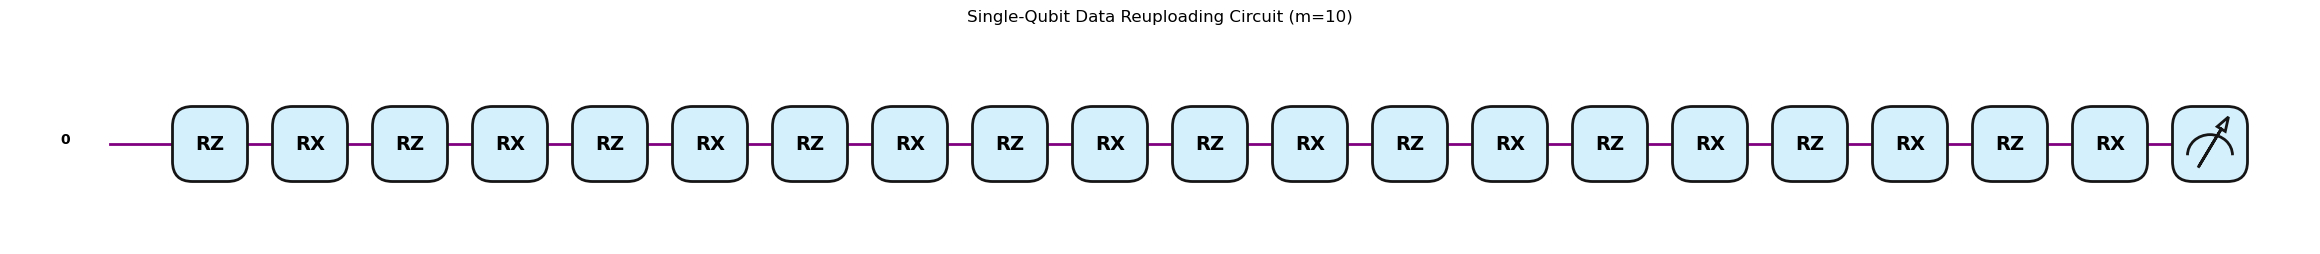

初始 thetas 前 5 元素： [5.542 1.257 3.075 7.04  5.867]
初始样本预测（expval Z）： -0.367


KeyboardInterrupt: 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 1. 数据准备
# ─────────────────────────────────────────────────────────────
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask   = (y == "0") | (y == "1")               # 只做 0 vs 1
X, y   = X[mask] / 255 * np.pi, y[mask].astype(int)

m = 10                                         # 降到 m 维
X = X[:, :m]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ─────────────────────────────────────────────────────────────
# 2. 单比特 Reupload QNN 定义
# ─────────────────────────────────────────────────────────────
dev = qml.device("lightning.qubit", wires=1)

@qml.qnode(dev, interface="autograd")
def single_qubit_reupload(x, thetas):
    for i in range(m):
        qml.RZ(x[i], wires=0)       # 数据编码
        qml.RX(thetas[i], wires=0)  # 可训练旋转
    return qml.expval(qml.PauliZ(0))

# ─────────────────────────────────────────────────────────────
# 3. 彩色电路可视化（训练前示意）
# ─────────────────────────────────────────────────────────────
# 初始化一套随机参数用于画图
np.random.seed(0)
thetas_viz = np.random.normal(0, np.pi, (m,))

qml.drawer.use_style("pennylane")
drawer = qml.draw_mpl(
    single_qubit_reupload,
    wire_order=[0],
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "purple", "linewidth": 2},
    label_options={"size": 10, "color": "black"},
    max_length=100  # 展开所有 m=10 重传门组
)
fig, ax = drawer(X_train[0], thetas_viz)
ax.set_title("Single‑Qubit Data Reuploading Circuit (m=10)", pad=16)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 4. 初始化参数、优化器 & 中间打印设定
# ─────────────────────────────────────────────────────────────
np.random.seed(0)
thetas = np.random.normal(0, np.pi, (m,), requires_grad=True)
opt    = qml.GradientDescentOptimizer(stepsize=0.1)

def loss_fn(t):
    preds = np.array([single_qubit_reupload(x, t) for x in X_train])
    return np.mean((preds - (1 - 2 * y_train)) ** 2)

print("初始 thetas 前 5 元素：", np.round(thetas[:5], 3))
print("初始样本预测（expval Z）：", 
      np.round(single_qubit_reupload(X_train[0], thetas), 3))

# ─────────────────────────────────────────────────────────────
# 5. 训练循环（带中间结果打印）
# ─────────────────────────────────────────────────────────────
epochs = 20
for epoch in range(1, epochs + 1):
    thetas, loss = opt.step_and_cost(loss_fn, thetas)

    # 每 5 epochs 打印一次参数和预测
    if epoch % 5 == 0 or epoch == 1:
        sample_val = single_qubit_reupload(X_train[0], thetas)
        print(f"\nEpoch {epoch:2d}: loss={loss:.4f}")
        print("  thetas[:5] =", np.round(thetas[:5], 3))
        print("  sample expval Z =", np.round(sample_val, 3))

    # 计算 train/test acc
    preds_train = np.array([single_qubit_reupload(x, thetas) for x in X_train]) > 0
    preds_test  = np.array([single_qubit_reupload(x, thetas) for x in X_test ]) > 0
    train_acc = np.mean(preds_train == (y_train == 0))
    test_acc  = np.mean(preds_test  == (y_test  == 0))

    print(f"  → train_acc={train_acc:.3f}, test_acc={test_acc:.3f}")

print("\n训练结束，最终 thetas 前 5：", np.round(thetas[:5],3))
